<a href="https://colab.research.google.com/github/nifemi-alonge/EPF/blob/main/NG_EPF_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Questions

**Please note** that we might not have enough time to go through all of these questions during the interview. However, we will read through your answers before the interview, so please make sure to explain your reasoning in sufficient detail.

1. **Briefly explain conceptually how you would approach this problem**
2. **Present your final model, how the results compare to ground truth and your observations**
3. **Describe your feature selection process**
4. **Compare the performance of your models and describe how you selected the best performing one**
5. **What (if any) simplifying assumptions did you have to make? What additional insight/analysis/data would be required to make your model more robust?**
6. **How would you productionise a model run on a local PC on VBA which takes 10 hours runtime?**
7. **Given we combine separate analysis such as power system software (e.g. PLEXOS), external APIs, and local CSV files, what architectural and process consideration do you need to make when developing and running a model?**

## Answers

1.

## Set up

### Packages

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

### Set paths

In [194]:
data_path = "/content/drive/MyDrive/Work/National_Grid_Lead_Data_Scientist_Interview/NG_coding_exercise_EPF/data/"
output_path = "/content/drive/MyDrive/Work/National_Grid_Lead_Data_Scientist_Interview/output/"

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Utility Functions

In [201]:
# convert date to datetime type FUNCTION
def preprocess_datetime_column(df, datetime_column):
    # Check the data type of the 'Datetime (UTC)' column
    original_dtype = df[datetime_column].dtypes

    # Convert the datetime_column  to datetime with UTC timezone
    df[datetime_column] = pd.to_datetime(df[datetime_column], utc=True)

    # Check the data type of the datetime_columnafter conversion
    new_dtype = df[datetime_column].dtypes

    return original_dtype, new_dtype

## Load in data

### Demand

In [256]:
# demand data
demand_df = pd.read_csv(data_path + 'demand/' + 'demand.csv')
demand_df.head()

,Datetime,Country,Source,Demand (MW)
0,2015-01-01 00:00:00+00:00,BE,ENTSOe,9555.0
1,2015-01-01 01:00:00+00:00,BE,ENTSOe,9094.0
2,2015-01-01 02:00:00+00:00,BE,ENTSOe,8691.0
3,2015-01-01 03:00:00+00:00,BE,ENTSOe,8354.0
4,2015-01-01 04:00:00+00:00,BE,ENTSOe,8080.0


In [257]:
# convert date to datetime type
original_dtype, new_dtype = preprocess_datetime_column(demand_df, 'Datetime')

print(f"Original datetime column data type: {original_dtype}")
print(f"New datetime column data type: {new_dtype}")
demand_df.head()

Original datetime column data type: object
New datetime column data type: datetime64[ns, UTC]


,Datetime,Country,Source,Demand (MW)
0,2015-01-01 00:00:00+00:00,BE,ENTSOe,9555.0
1,2015-01-01 01:00:00+00:00,BE,ENTSOe,9094.0
2,2015-01-01 02:00:00+00:00,BE,ENTSOe,8691.0
3,2015-01-01 03:00:00+00:00,BE,ENTSOe,8354.0
4,2015-01-01 04:00:00+00:00,BE,ENTSOe,8080.0


In [ ]:
# CHECK
demand_df['Datetime'].min()
demand_df['Datetime'].max()

Timestamp('2020-12-31 23:00:00+0000', tz='UTC')

### GB Demand

In [258]:
# create GB demand
gb_demand_df = demand_df[demand_df['Country'] == 'GB']

### Other Demand

In [275]:
be_demand_df = demand_df[demand_df['Country'] == 'BE']
dk_demand_df = demand_df[demand_df['Country'] == 'DK']
fr_demand_df = demand_df[demand_df['Country'] == 'FR']
de_demand_df = demand_df[demand_df['Country'] == 'DE']
ie_demand_df = demand_df[demand_df['Country'] == 'IE']
nl_demand_df = demand_df[demand_df['Country'] == 'NL']
# no Norway

In [279]:
# List of DataFrames
add_demand = [be_demand_df, dk_demand_df, fr_demand_df, de_demand_df,
                   ie_demand_df, nl_demand_df]

# Define a list of country names corresponding to each DataFrame
country_names = ['belgium', 'denmark', 'france', 'germany', 'ireland',
                 'netherlands']

# Initialize an empty DataFrame to store the merged data
add_demand_df = pd.DataFrame()

# Iterate through the list of DataFrames
for df, country_name in zip(add_demand, country_names):
    # Remove duplicate datetime values within each DataFrame
    df = df.drop_duplicates(subset='Datetime', keep='first')

    # Subset only the 'Datetime' and 'Demand (MW)' columns
    subset_df = df[['Datetime', 'Demand (MW)']]

    # Rename the 'Demand (MW)' column to the country-specific name
    subset_df.rename(columns={'Demand (MW)': f'{country_name}_demand'}, inplace=True)

    # Merge the subset DataFrame with the merged DataFrame
    if add_demand_df.empty:
        add_demand_df = subset_df
    else:
        # Perform a left merge to avoid duplicate rows
        add_demand_df = pd.merge(add_demand_df, subset_df, on='Datetime', how='left')

# Now you have a single DataFrame with datetime and demand columns for each country
add_demand_df.head()

<ipython-input-279-32f2c7bcce4c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={'Demand (MW)': f'{country_name}_demand'}, inplace=True)
<ipython-input-279-32f2c7bcce4c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={'Demand (MW)': f'{country_name}_demand'}, inplace=True)
<ipython-input-279-32f2c7bcce4c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={

,Datetime,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
0,2015-01-01 00:00:00+00:00,9555.0,3337.9,71506.350,47445.360,2849.0,11586.0
1,2015-01-01 01:00:00+00:00,9094.0,3223.2,71134.370,45923.710,2651.0,11338.0
2,2015-01-01 02:00:00+00:00,8691.0,3090.7,68840.400,44295.875,2412.0,10917.0
3,2015-01-01 03:00:00+00:00,8354.0,2953.4,65749.414,42868.043,2256.0,10473.0
4,2015-01-01 04:00:00+00:00,8080.0,2888.7,64041.330,42230.930,2170.0,10200.0


### GB Prices

In [261]:
# GB price data
gb_prices_df = pd.read_csv(data_path + 'prices/' + 'Great Britain.csv')
gb_prices_df.head()

,Country,ISO3 Code,Datetime (UTC),Price (GBP/MWhe)
0,Great Britain,GBR,01/01/2015 00:00,0
1,Great Britain,GBR,01/01/2015 01:00,0
2,Great Britain,GBR,01/01/2015 02:00,0
3,Great Britain,GBR,01/01/2015 03:00,0
4,Great Britain,GBR,01/01/2015 04:00,0


In [262]:
# convert date to datetime type
original_dtype, new_dtype = preprocess_datetime_column(gb_prices_df, 'Datetime (UTC)')

print(f"Original datetime column data type: {original_dtype}")
print(f"New datetime column data type: {new_dtype}")
gb_prices_df.head()

Original datetime column data type: object
New datetime column data type: datetime64[ns, UTC]


,Country,ISO3 Code,Datetime (UTC),Price (GBP/MWhe)
0,Great Britain,GBR,2015-01-01 00:00:00+00:00,0
1,Great Britain,GBR,2015-01-01 01:00:00+00:00,0
2,Great Britain,GBR,2015-01-01 02:00:00+00:00,0
3,Great Britain,GBR,2015-01-01 03:00:00+00:00,0
4,Great Britain,GBR,2015-01-01 04:00:00+00:00,0


In [143]:
# CHECK
gb_prices_df['Datetime (UTC)'].min()
gb_prices_df['Datetime (UTC)'].max()

Timestamp('2020-12-31 23:00:00+0000', tz='UTC')

### Other Prices

In [263]:
# other prices
be_prices_df = pd.read_csv(data_path + 'prices/' + 'Belgium.csv')
dk_prices_df = pd.read_csv(data_path + 'prices/' + 'Denmark.csv')
fr_prices_df = pd.read_csv(data_path + 'prices/' + 'France.csv')
de_prices_df = pd.read_csv(data_path + 'prices/' + 'Germany.csv')
ie_prices_df = pd.read_csv(data_path + 'prices/' + 'Ireland.csv')
nl_prices_df = pd.read_csv(data_path + 'prices/' + 'Netherlands.csv')
no_prices_df = pd.read_csv(data_path + 'prices/' + 'Norway.csv')

In [264]:
# convert date to datetime type

# List of DataFrames
add_prices = [be_prices_df, dk_prices_df, fr_prices_df, de_prices_df,
                   ie_prices_df, nl_prices_df, no_prices_df]

# Specify the column name
column_name = 'Datetime (UTC)'

# Apply the function to each DataFrame in the list
for df in add_prices:
    original_dtype, new_dtype = preprocess_datetime_column(df, column_name)
    print(f"Original 'Datetime (UTC)' column data type: {original_dtype}")
    print(f"New 'Datetime (UTC)' column data type: {new_dtype}")

Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]


In [265]:
# Define a list of country names corresponding to each DataFrame
country_names = ['belgium', 'denmark', 'france', 'germany', 'ireland',
                 'netherlands', 'norway']

# Initialize an empty DataFrame to store the merged data
add_prices_df = pd.DataFrame()

# Iterate through the list of DataFrames
for df, country_name in zip(add_prices, country_names):
    # Subset only the 'datetime' and 'price_' columns
    subset_df = df[['Datetime (UTC)', 'Price (EUR/MWhe)']]

    # Rename the 'price_' column to the country-specific name
    subset_df.rename(columns={'Price (EUR/MWhe)': f'{country_name}_price'}, inplace=True)

    # Merge the subset DataFrame with the merged DataFrame
    if add_prices_df.empty:
        add_prices_df = subset_df
    else:
        add_prices_df = pd.merge(add_prices_df, subset_df, on='Datetime (UTC)', how='outer')

# Now you have a single DataFrame with datetime and price columns for each country
add_prices_df.head()

<ipython-input-265-f30a19ae5cfc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={'Price (EUR/MWhe)': f'{country_name}_price'}, inplace=True)
<ipython-input-265-f30a19ae5cfc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={'Price (EUR/MWhe)': f'{country_name}_price'}, inplace=True)
<ipython-input-265-f30a19ae5cfc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(c

,Datetime (UTC),belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price
0,2015-01-01 00:00:00+00:00,34.94,18.29,34.94,17.93,138.97,34.94,27.36
1,2015-01-01 01:00:00+00:00,32.19,16.04,32.19,15.17,74.78,32.19,27.24
2,2015-01-01 02:00:00+00:00,28.05,14.60,23.53,16.38,72.99,28.05,27.16
3,2015-01-01 03:00:00+00:00,28.04,14.95,22.92,17.38,78.79,28.04,27.15
4,2015-01-01 04:00:00+00:00,34.26,14.50,34.26,16.38,84.79,34.26,27.30


### GB Weather

In [266]:
# GB weather data - daily
weather_df = pd.read_excel(data_path + 'weather/' + 'UK_daily_temp.xlsx')
weather_df.head()

,Datetime,Temperature (Celsius)
0,20150101,7.5
1,20150102,6.9
2,20150103,3.7
3,20150104,1.5
4,20150105,3.9


In [66]:
# CHECK
weather_df['Datetime'].min()
weather_df['Datetime'].max()

Timestamp('2020-12-31 00:00:00+0000', tz='UTC')

In [267]:
# convert date to datetime type
# Convert the integer column to a string
weather_df['Datetime'] = weather_df['Datetime'].astype(str)

# Use string formatting to create the desired format
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d')

# Set the UTC timezone to the datetime column
weather_df['Datetime'] = weather_df['Datetime'].dt.tz_localize('UTC')

In [42]:
# CHECK
weather_df['Datetime'].min()
weather_df['Datetime'].max()

Timestamp('2020-12-31 00:00:00+0000', tz='UTC')

## Creating combined dataset

In [281]:
gb_dataset = pd.merge(gb_prices_df, gb_demand_df[['Demand (MW)', 'Datetime']], left_on='Datetime (UTC)', right_on='Datetime', how='left')
gb_dataset = pd.merge(gb_dataset, weather_df, left_on='Datetime (UTC)', right_on='Datetime', how='left')
gb_dataset = pd.merge(gb_dataset, add_prices_df, on='Datetime (UTC)', how='left')
gb_dataset = pd.merge(gb_dataset, add_demand_df, left_on='Datetime (UTC)', right_on='Datetime', how='left')

# forward fill temperature
gb_dataset['Temperature (Celsius)'].ffill(inplace=True)

# Drop the duplicate 'Datetime' columns
gb_dataset.drop(columns=['Datetime_x', 'Datetime_y'], inplace=True)

# Specify the columns you want to drop in a list
columns_to_drop = ['Country', 'ISO3 Code', 'Datetime']

# Use the drop method to remove the specified columns
gb_dataset.drop(columns=columns_to_drop, inplace=True)  # Set inplace=True to modify the DataFrame in place

# Define a dictionary to map old column names to new column names
column_rename_mapping = {
    'Datetime (UTC)': 'Datetime',
    'Price (GBP/MWhe)': 'gb_price',
    'Demand (MW)': 'gb_demand',
    'Temperature (Celsius)': 'gb_temp'
}

# Use the rename method to rename the specified columns
gb_dataset.rename(columns=column_rename_mapping, inplace=True)  # Set inplace=True to modify the DataFrame in place

gb_dataset.tail()

,Datetime,gb_price,gb_demand,gb_temp,belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
52603,2020-12-31 19:00:00+00:00,61.04,38697.5,-1.3,56.79,56.70,56.75,56.70,64.28,56.64,23.88,9794.50,4091.0,66763.0,51019.75,4259.0,12977.25
52604,2020-12-31 20:00:00+00:00,60.39,35833.0,-1.3,52.44,52.44,52.44,52.44,62.66,52.44,23.80,9386.25,3874.0,64102.0,48681.25,3954.0,12278.75
52605,2020-12-31 21:00:00+00:00,57.96,33026.5,-1.3,51.86,51.86,51.86,51.86,56.90,51.86,23.67,9582.00,3674.0,65097.0,47451.00,3689.5,11835.50
52606,2020-12-31 22:00:00+00:00,55.02,30714.5,-1.3,52.26,52.26,52.26,52.26,50.70,52.26,23.00,9683.50,3506.0,66913.0,45235.25,3467.5,11573.75
52607,2020-12-31 23:00:00+00:00,n/e,28975.0,-1.3,50.87,50.87,50.87,50.87,55.09,50.87,23.79,9296.00,3482.0,65761.0,44586.00,3423.5,11409.50


In [282]:
# dealing with missing price value fpr 2020-12-31 23:00:00+00:00
gb_dataset['gb_price'].dtypes # price has strings

# there is one price value with 'n/e' in it
# imputing this price value

# Find the index where 'n/e' appears in the Price column
index_to_replace = gb_dataset.index[gb_dataset['gb_price'] == 'n/e'].tolist()[0]

# Calculate the imputed value based on previous values (e.g., taking the mean)
# considering from 52603 as this is when value decline and are similar
previous_values = gb_dataset.loc[52603:index_to_replace - 1, 'gb_price']
imputed_value = np.mean(previous_values.astype(float))  # Assuming you want to use the mean

imputed_value = round(imputed_value, 2)

# Replace 'n/e' with the imputed value
gb_dataset.at[index_to_replace, 'gb_price'] = imputed_value

#gb_dataset['gb_price'] = gb_dataset['gb_price'].astype(float)

gb_dataset.tail(10)

,Datetime,gb_price,gb_demand,gb_temp,belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
52598,2020-12-31 14:00:00+00:00,62.09,36984.0,-1.3,56.54,56.54,56.54,56.54,64.51,56.54,26.77,10097.00,4379.0,65356.0,51943.25,4133.5,14076.25
52599,2020-12-31 15:00:00+00:00,57.54,38563.5,-1.3,59.20,59.20,59.20,59.20,60.60,59.20,29.76,10176.75,4650.0,64941.0,54467.75,4135.0,14367.25
52600,2020-12-31 16:00:00+00:00,76,40957.5,-1.3,61.34,61.34,61.34,61.34,68.35,61.34,28.09,10685.50,4903.0,67855.0,57484.75,4265.5,15057.25
52601,2020-12-31 17:00:00+00:00,106.5,42639.5,-1.3,61.08,61.08,61.08,61.08,84.54,61.08,25.93,10591.75,4817.0,69899.0,57848.00,4625.0,14524.50
52602,2020-12-31 18:00:00+00:00,71.3,41573.0,-1.3,61.51,59.47,60.54,59.47,69.55,57.99,24.64,10244.00,4353.0,69479.0,54987.75,4569.0,13822.75
52603,2020-12-31 19:00:00+00:00,61.04,38697.5,-1.3,56.79,56.70,56.75,56.70,64.28,56.64,23.88,9794.50,4091.0,66763.0,51019.75,4259.0,12977.25
52604,2020-12-31 20:00:00+00:00,60.39,35833.0,-1.3,52.44,52.44,52.44,52.44,62.66,52.44,23.80,9386.25,3874.0,64102.0,48681.25,3954.0,12278.75
52605,2020-12-31 21:00:00+00:00,57.96,33026.5,-1.3,51.86,51.86,51.86,51.86,56.90,51.86,23.67,9582.00,3674.0,65097.0,47451.00,3689.5,11835.50
52606,2020-12-31 22:00:00+00:00,55.02,30714.5,-1.3,52.26,52.26,52.26,52.26,50.70,52.26,23.00,9683.50,3506.0,66913.0,45235.25,3467.5,11573.75
52607,2020-12-31 23:00:00+00:00,58.6,28975.0,-1.3,50.87,50.87,50.87,50.87,55.09,50.87,23.79,9296.00,3482.0,65761.0,44586.00,3423.5,11409.50


## Modelling

In [283]:
# define train test split and features for all models

gb_dataset.dropna(inplace=True)

# Split the data into training and testing datasets based on date
train_data = gb_dataset[gb_dataset['Datetime'].dt.year < 2020]  # Data from 2015-2019
test_data = gb_dataset[gb_dataset['Datetime'].dt.year == 2020]  # Data for 2020

# Define your feature columns
features = ['gb_demand', 'gb_price', 'gb_temp']
# additional
features_prices = ['gb_demand', 'gb_price', 'gb_temp', 'belgium_price',
                   'denmark_price', 'france_price', 'germany_price',
                   'ireland_price',	'netherlands_price',	'norway_price']

# additional
features_demand = ['gb_demand', 'gb_price', 'gb_temp', 'belgium_price',
                   'denmark_price', 'france_price', 'germany_price',
                   'ireland_price',	'netherlands_price',	'norway_price',
                   'belgium_demand',	'denmark_demand',	'france_demand',
                   'germany_demand',	'ireland_demand',	'netherlands_demand']

### Model 1 - Linear Regression

In [233]:
# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
lr_predicted_2020_prices = model.predict(test_data[features])

# Round predicted prices to 1 decimal place
lr_predicted_2020_prices = np.round(lr_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
lr_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': lr_predicted_2020_prices})

# Save results to CSV
lr_results_df.to_csv(output_path + 'predicted_prices_2020_linear_reg.csv', index=False)

Root Mean Squared Error (RMSE): 4.909244538553793e-15
R-squared: 1.00
Mean Absolute Error (MAE): 2.8317010778563455e-15


In [241]:
# USING OTHER PRICES
# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(train_data[features_prices], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_prices])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_prices], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
lr_predicted_2020_prices = model.predict(test_data[features_prices])

# Round predicted prices to 1 decimal place
lr_predicted_2020_prices = np.round(lr_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
lr_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': lr_predicted_2020_prices})

# Save results to CSV
lr_results_df.to_csv(output_path + 'predicted_prices_2020_linear_reg_prices.csv', index=False)

Root Mean Squared Error (RMSE): 3.4637865814993504e-14
R-squared: 1.00
Mean Absolute Error (MAE): 2.9970444468829956e-14


In [ ]:
# USING OTHER DEMAND
# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(train_data[features_demand], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_demand])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_demand], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
lr_predicted_2020_prices = model.predict(test_data[features_demand])

# Round predicted prices to 1 decimal place
lr_predicted_2020_prices = np.round(lr_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
lr_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': lr_predicted_2020_prices})

# Save results to CSV
lr_results_df.to_csv(output_path + 'predicted_prices_2020_linear_reg_prices.csv', index=False)

### Model 2 - XGBoost

In [234]:
# Initialize and train an XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
xgb_predicted_2020_prices = model.predict(test_data[features])

# Round predicted prices to 1 decimal place
xgb_predicted_2020_prices = np.round(xgb_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
xgb_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': xgb_predicted_2020_prices})

# Save results to CSV
xgb_results_df.to_csv(output_path + 'predicted_prices_2020_xgboost.csv', index=False)

Root Mean Squared Error (RMSE): 1.2571083787532757
R-squared: 0.99
Mean Absolute Error (MAE): 0.12962411200032675


In [239]:
# USING OTHER PRICES

# Initialize and train an XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(train_data[features_prices], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_prices])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_prices], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
xgb_predicted_2020_prices = model.predict(test_data[features_prices])

# Round predicted prices to 1 decimal place
xgb_predicted_2020_prices = np.round(xgb_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
xgb_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': xgb_predicted_2020_prices})

# Save results to CSV
xgb_results_df.to_csv(output_path + 'predicted_prices_2020_xgboost_prices.csv', index=False)

Root Mean Squared Error (RMSE): 1.272198761526535
R-squared: 0.99
Mean Absolute Error (MAE): 0.13510713453198733


In [ ]:
# USING OTHER DEMAND

# Initialize and train an XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(train_data[features_demand], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_demand])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_demand], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
xgb_predicted_2020_prices = model.predict(test_data[features_demand])

# Round predicted prices to 1 decimal place
xgb_predicted_2020_prices = np.round(xgb_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
xgb_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': xgb_predicted_2020_prices})

# Save results to CSV
xgb_results_df.to_csv(output_path + 'predicted_prices_2020_xgboost_prices.csv', index=False)

### Model 3 - Random Forest

In [235]:
# Initialize and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
rf_predicted_2020_prices = model.predict(test_data[features])

# Round predicted prices to 1 decimal place
rf_predicted_2020_prices = np.round(rf_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
rf_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': rf_predicted_2020_prices})

# Save results to CSV
rf_results_df.to_csv(output_path + 'predicted_prices_2020_random_forest.csv', index=False)

Root Mean Squared Error (RMSE): 1.3552923898076183
R-squared: 0.99
Mean Absolute Error (MAE): 0.09686979735885157


In [240]:
# USING OTHER PRICES

# Initialize and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(train_data[features_prices], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_prices])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_prices], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
rf_predicted_2020_prices = model.predict(test_data[features_prices])

# Round predicted prices to 1 decimal place
rf_predicted_2020_prices = np.round(rf_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
rf_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': rf_predicted_2020_prices})

# Save results to CSV
rf_results_df.to_csv(output_path + 'predicted_prices_2020_random_forest_prices.csv', index=False)

Root Mean Squared Error (RMSE): 1.4218959739416663
R-squared: 0.99
Mean Absolute Error (MAE): 0.10243455145720788


In [ ]:
# USING OTHER DEMAND

# Initialize and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(train_data[features_demand], train_data['gb_price'])  # Assuming you want to predict 'price'

# Make predictions on the test set
y_pred = model.predict(test_data[features_demand])

# Evaluate the model
rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_data['gb_price'], y_pred)
print(f"R-squared: {r2:.2f}")

mae = mean_absolute_error(test_data['gb_price'], y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Train the final model on the full dataset
model.fit(gb_dataset[features_demand], gb_dataset['gb_price'])  # Using the entire dataset for training

# Predict electricity prices for 2020
rf_predicted_2020_prices = model.predict(test_data[features_demand])

# Round predicted prices to 1 decimal place
rf_predicted_2020_prices = np.round(rf_predicted_2020_prices, 1)

# Create a DataFrame with datetime and predicted prices
rf_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': rf_predicted_2020_prices})

# Save results to CSV
rf_results_df.to_csv(output_path + 'predicted_prices_2020_random_forest_prices.csv', index=False)

## Evaluation

### Visualisation

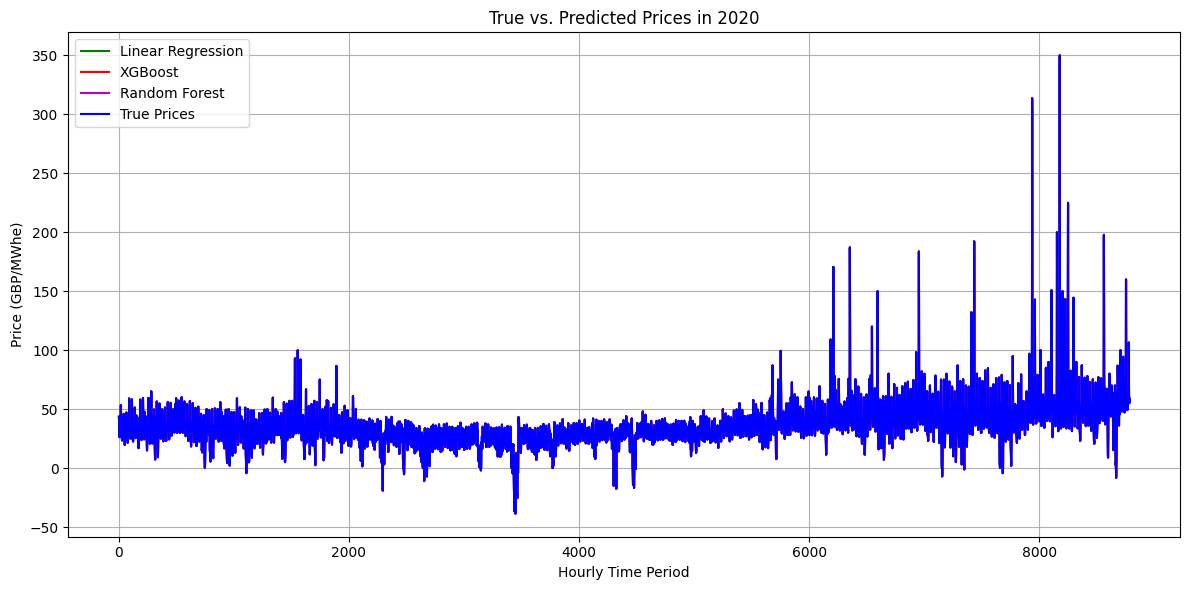

In [231]:
# Sample data for true 2020 hourly prices (replace this with your actual data)
true_prices = test_data['gb_price']

# Sample data for predicted prices by each model (replace these with your actual predictions)
linear_regression_predictions = lr_predicted_2020_prices  # Replace with actual predictions
xgboost_predictions = xgb_predicted_2020_prices # Replace with actual predictions
random_forest_predictions = rf_predicted_2020_prices # Replace with actual predictions

# Create a list of hours (assuming you have hourly data)
hours = range(1, len(true_prices) + 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted prices for each model
ax.plot(hours, linear_regression_predictions, label='Linear Regression', linestyle='-',  color='g')
ax.plot(hours, xgboost_predictions, label='XGBoost', linestyle='-', color='r')
ax.plot(hours, random_forest_predictions, label='Random Forest', linestyle='-',  color='m')

# Plot the true 2020 hourly prices
ax.plot(hours, true_prices, label='True Prices', linestyle='-', color='b')

# Set plot labels and title
ax.set_xlabel('Hourly Time Period')
ax.set_ylabel('Price (GBP/MWhe)')
ax.set_title('True vs. Predicted Prices in 2020')

# Add a legend
ax.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()